## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random
import os

import sinogap_module_exp as sg




### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223
sg.plt.rcParams['axes.spines.left'] = False
sg.plt.rcParams['axes.spines.right'] = False
sg.plt.rcParams['axes.spines.top'] = False
sg.plt.rcParams['axes.spines.bottom'] = False




### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 1
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**8
    ,batchSplit = 2**2
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 1e-3
    ,learningRateG = 1e-3
    ,dataDir = '/dev/shm/sinogapData'
)

sg.DCfg = sg.DCfgClass(2,False)


os.environ["CTAS_MMAP_PATH"] = "/mnt/ssdData/"


### <font style="color:lightblue">Raw Read</font>

In [ ]:
sg.trainSet = sg.createDataSet(sg.TCfg.dataDir, sg.listOfTrainData, exclusive=True)
sg.testSet = sg.createDataSet(sg.TCfg.dataDir+"/test", sg.listOfTestData, exclusive=True)

['/dev/shm/sinogapData/18692a.ExpChicken6mGyShift', '/dev/shm/sinogapData/23574.8965435L.Eiger.32kev_sft', '/dev/shm/sinogapData/19022g.11-EggLard', '/dev/shm/sinogapData/18692b.MinceO', '/dev/shm/sinogapData/23574.8965435L.Eiger.32kev_org', '/dev/shm/sinogapData/19736b.09_Feb.4176862R_Eig_Threshold-4keV', '/dev/shm/sinogapData/20982b.04_774784R', '/dev/shm/sinogapData/18515.Lamb1_Eiger_7m_45keV_360Scan', '/dev/shm/sinogapData/19736c.8733147R_Eig_Threshold-8keV.SAMPLE_Y1', '/dev/shm/sinogapData/18692b_input_PhantomM', '/dev/shm/sinogapData/21836b.2024-08-15-mastectomies.4201381L.35kev.20Hz', '/dev/shm/sinogapData/23574h.9230799R.35kev', '/dev/shm/sinogapData/18515.Lamb4_Excised_Eiger_7m_30keV_360Scan.Y1', '/dev/shm/sinogapData/18648.B_Edist.80keV_0m_Eig_Neoprene.Y2', '/dev/shm/sinogapData/19932.10_8093920_35keV', '/dev/shm/sinogapData/19932.14_2442231_23keV', '/dev/shm/sinogapData/19932.16_4193759_60keV']
Loading train set 1 of 17: /dev/shm/sinogapData/18692a.ExpChicken6mGyShift ... Do

### <font style="color:lightblue">Show</font>

2072 (0, 0, 132, 773)
3.279e-01, 3.544e-01, 4.438e-03, 9.889e-01


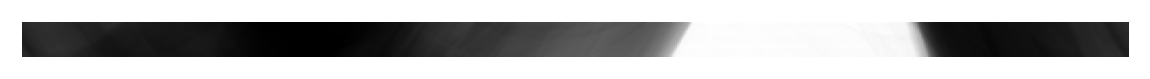

In [ ]:
sg.examples = [
    ((3, 476, 2880), 0.78),
    ((2, 118,  988), 0.89),
    ((0, 298, 1557), 0.846),
    ((3, 925,  592), 0.35)
]

sg.refImages, sg.refNoises, sg.refBoxes = sg.createReferences(sg.testSet, 0)
sg.showMe(sg.testSet)
#sg.displayImages()


## <font style="color:lightblue">Models</font>

### Generator 2pix

In [ ]:
class BricksGenerator2(sg.SubGeneratorTemplate) :
    # 'Adv'    : 0.000e+00
    # 'MSE'    : 8.799e-03
    # 'MSEN'   : 5.276e+00
    # 'L1L'    : 1.290e-01
    # 'L1LN'   : 7.558e+00
    # 'SSIM'   : 4.114e-04
    # 'MSSSIM' : 3.784e-06
    def __init__(self):
        super(BricksGenerator2, self).__init__(2, True, batchNorm=True)
        self.baseChannels = 64
        self.encoders =  nn.ModuleList([
            self.encblock( self.inChannels/self.baseChannels,
                               1, 3, norm=False),
            self.encblock(  1, 2, 3, stride=2),
            self.encblock(  2, 2, 3),
            self.encblock(  2, 4, 3, stride=2),
            self.encblock(  4, 4, 3),
            self.encblock(  4, 8, 3, stride=2),
            ])
        self.fcLink = self.createFClink()
        self.decoders = nn.ModuleList([
            self.decblock(16, 4, 3, stride=2),
            self.decblock( 8, 4, 3),
            self.decblock( 8, 2, 3, stride=2),
            self.decblock( 4, 2, 3),
            self.decblock( 4, 1, 3, stride=2),
            self.decblock( 2, 1, 3, norm=False),
            ])
        self.lastTouch = self.createLastTouch()


class Generator2(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator2, self).__init__(2, inChannels=3, batchNorm=True)
        self.brickGenerator = None
        self.baseChannels = 4

        self.baseChannels = 4
        self.encoders =  nn.ModuleList([
            self.encblock(  self.inChannels/self.baseChannels,
                               1, 3, norm=False),
            self.encblock(  1, 2, 3, stride=2),
            self.encblock(  2, 2, 3),
            self.encblock(  2, 4, 3, stride=2),
            self.encblock(  4, 4, 3),
            self.encblock(  4, 8, 3, stride=2),
            ])
        self.fcLink = self.createFClink()
        self.decoders = nn.ModuleList([
            self.decblock(16, 4, 3, stride=2),
            self.decblock( 8, 4, 3),
            self.decblock( 8, 2, 3, stride=2),
            self.decblock( 4, 2, 3),
            self.decblock( 4, 1, 3, stride=2),
            self.decblock( 2, 1, 3, padding=1, norm=False),
            ])
        self.lastTouch = self.createLastTouch()
        #sg.load_model(self, model_path="model_2_gen.pt" )


generator = Generator2()
generator = generator.to(sg.TCfg.device)

model_summary = summary(generator, input_data=[ sg.refImages[[0],...] ] ).__str__()
print(model_summary)

sg.generator = generator




### <font style="color:lightblue">Generator</font>

In [ ]:
#sg.generator = sg.lowResGenerators[sg.DCfg.gapW]
sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)
#model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
#print(sg.refImages.shape, sg.refImages[[0],...].shape)
#print(model_summary)


### <font style="color:lightblue">Discriminator</font>

In [ ]:

class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.param = nn.Parameter(torch.zeros(1))
    def forward(self, images):
        return torch.zeros((images.shape[0],1), device=sg.TCfg.device)

sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)



## <font style="color:lightblue">Norms</font>

In [ ]:
sg.dataLoader = sg.createDataLoader(sg.trainSet, shuffle=True, num_workers=16)
sg.testLoader = sg.createDataLoader(sg.testSet, shuffle=False)

#_ = sg.summarizeMe(sg.testLoader, True)
#_ = sg.summarizeMe(sg.testLoader, False)
#_ = sg.summarizeMe(sg.dataLoader, True)
#_ = sg.summarizeMe(sg.dataLoader, False)
#sg.displayImages()

### no prenorm

sg.metrices = {
    'Adv'    : sg.Metrics(sg.loss_Adv_Gen, 0.000e+00, 0),
    'MSE'    : sg.Metrics(sg.loss_MSE,     8.799e-03, 1),
    'MSEN'   : sg.Metrics(sg.loss_MSEN,    5.276e+00, 0),
    'L1L'    : sg.Metrics(sg.loss_L1L,     1.290e-01, 0),
    'L1LN'   : sg.Metrics(sg.loss_L1LN,    7.558e+00, 0),
    'SSIM'   : sg.Metrics(sg.loss_SSIM,    4.114e-04, 0),
    'MSSSIM' : sg.Metrics(sg.loss_MSSSIM,  3.784e-06, 0),
}

#sg.displayImages()

## <font style="color:lightblue">Restore checkpoint</font>

In [ ]:

sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1)
#sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1)
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint()#savedCheckPoint+".pth")
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)



sg.scheduler_G.gamma = 1-0.01
#sg.scheduler_D.gamma = 1-0.005
#sg.optimizer_G.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 1).step()
#sg.optimizer_D.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_D, lambda epoch: 0.05).step()

print(f"Initial LR : G {sg.scheduler_G.get_last_lr()[0]:.3e} ({sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG:.4f})")
                  #f" D {sg.scheduler_D.get_last_lr()[0]:.3e} ({sg.scheduler_D.get_last_lr()[0]/sg.TCfg.learningRateD:.4f}), Epoch {sg.epoch} {sg.imer}")


In [ ]:
sg.displayImages()
#_ = sg.summarizeMe(sg.testLoader, False)

## <font style="color:lightblue">Execute</font>

In [ ]:


sg.scheduler_G.gamma = 1-0.003
def my_beforeReport(sglocals) :
    message = ""

    message += "G" + sg.adjustScheduler(sg.scheduler_G, sg.TCfg.learningRateG, 0.0001)
    sg.writer.add_scalars("Aux", {'LrnRate': sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG}, sg.imer)

    #for metrics in ('L1L','SSIM','MSSSIM') :
    #    sg.metrices[metrics].weight = max(0, sg.metrices[metrics].weight - 0.005)
    #    message += f"{metrics} weight: {sg.metrices[metrics].weight}. "
    #    sg.writer.add_scalars("Aux", {metrics: sg.metrices[metrics].weight}, sg.imer)

    print(message)
    return
#sg.beforeReport = my_beforeReport

def my_afterEachEpoch(sglocals) :
    sg.TCfg.batchSize = min(2**16, sg.TCfg.batchSize * 2)
    sg.TCfg.batchSplit = max(2**0, int(sg.TCfg.batchSize / 2**12))
    sg.writer.add_scalars("Aux", {'Batch size': math.log(sg.TCfg.batchSize,2)}, sg.imer)
    print(f"Batch size: {sg.TCfg.batchSize}, split: {sg.TCfg.batchSplit}", )
    return
#sg.afterEachEpoch = my_afterEachEpoch

try :
    sg.train(savedCheckPoint)
except :

    #del sg.dataLoader
    #del sg.testLoaderhuiVam
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.epoch -= 1
    raise



# loss MSE raw, BS=2**8, LR=1e-3


## <font style="color:lightblue">Post</font>

In [ ]:
sg.saveCheckPoint(savedCheckPoint+".pth",
                           sg.epoch+1, sg.imer, sg.minGEpoch, sg.minGLoss,
                           sg.generator, sg.discriminator,
                           sg.optimizer_G, sg.optimizer_D)


In [ ]:
for key in sg.resAcc.metrices.keys() :
    if sg.metrices[key].norm > 0 :
        sg.writer.add_scalars("Metrices_per_epoch", {key : sg.resAcc.metrices[key],}, sg.epoch )

resTest = sg.summarizeMe(sg.testLoader, False)
resTest *= 1/resTest.nofIm
sg.writer.add_scalars("Losses epoch test",
                   {'Dis': resTest.lossD
                   ,'Gen': resTest.lossG
                   #,'Adv' : resTest.metrices['Adv']
                   }, sg.epoch )
for key in resTest.metrices.keys() :
    if sg.metrices[key].norm > 0 :
        sg.writer.add_scalars("Metrices epoch test", {key : resTest.metrices[key],}, sg.epoch )
sg.writer.add_scalars("Probs epoch test",
                   {'Ref':resTest.predReal
                   ,'Gen':resTest.predFake
                   #,'Pre':trainRes.predGen
                   }, sg.epoch )





In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()